In [75]:
%reset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import argparse

from math import ceil, floor
from scipy.stats import pearsonr
from scipy.linalg import cholesky
from multiprocessing import Pool, Manager
from functools import partial
from time import perf_counter

%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [76]:
class StreamFlowsGeneration:
    
    
    def __init__(self, DataFrame, monthly=False, weekly=False, daily=False, sample_size=None, **kwargs):
        
        
        self.Qh      = DataFrame
        self.monthly = monthly
        self.weekly  = weekly
        self.daily   = daily
        self.sample  = sample_size
        
        self._Log_Qhmean = []
        self._Log_Qhstd  = []
        self._ncol   = 0
        
        
        if self.monthly == True:
            self._ncol  = 12
        
        if self.weekly == True:
            self._ncol = 52
            
        if self.daily == True:
            self._ncol = 365
               
    
    def Qh_shifting(self, New_DataFrame=None):
        
        
        if New_DataFrame is None:
            tem = self.Qh  
            
        else:            
            tem = New_DataFrame
            
        
        Qh_shifted = []
        
        if self.monthly == True or self.weekly == True:            
            div = int(self._ncol/2)
            
            Qh_shifted = tem[div:-div]
            
        if self.daily == True:
            div = int(np.floor(self._ncol/2))
            
            Qh_shifted = tem[div:-div-1]
        
        
        return Qh_shifted 
                  
  
    def formatting_Qh(self, shifted=None, New_DataFrame=None):
        
        
        if New_DataFrame is None:
            tem = self.Qh  
            
        else:            
            tem = New_DataFrame
            
        self._Qhmean = []
        self._Qhstd  = []    
        series       = []
        
        if shifted == False:
            series =  tem
                
        if shifted == True:
            series =  self.Qh_shifting(tem)
            
        
        j_len = series.shape[1]
        i_len = series.shape[0]

        Qh_matrix = []
        Qh_tem    = []
    
        for j in range(j_len):    
            
            for i in range(0, i_len, self._ncol):        
                tem_Qh = series.iloc[i:(i+self._ncol), j]
                tem_Qh = tem_Qh.reset_index(drop=True)
                
                Qh_tem.append(tem_Qh)
              
            tem2_Qh = pd.concat(Qh_tem, axis=1).T

            Qh_tem = []
        
            Qh_matrix.append(tem2_Qh)
            
        Qh_Locations = len(Qh_matrix)
        
        for L in range(Qh_Locations):            
            Qh_matrix[L] = Qh_matrix[L].dropna()
            
        
        return Qh_matrix
    
    
    def corr(self,matrix):
        c   = np.corrcoef(matrix, rowvar=False)    
        eig = np.linalg.eigvals(c)
    
        trigger = None
    
        if np.min(eig) < 0:        
            trigger = True
            
            #k = np.min([np.min(np.real(eig)) -1 * np.finfo(float).eps])
            #c += c - k * np.eye(*c.shape)
            
            c += 1e-14 * np.eye(*c.shape)
            c_final = c
           
        if trigger == None:
            c_final = c
    
        
        return c_final

        
    def standardise_streamflows(self, shifted=None, New_DataFrame=None):
        
        
        if New_DataFrame is None:
            tem = self.Qh  
            
        else:            
            tem = New_DataFrame
            
            
        self._Log_Qhmean = []
        self._Log_Qhstd  = []
       
        Log_Qh = []
        mean_tem  = []
        std_tem   = []
                
        if shifted == False:
            Log_Qh =  self.formatting_Qh(shifted=False, New_DataFrame=tem)
                
        if shifted == True:
            Log_Qh =  self.formatting_Qh(shifted=True, New_DataFrame=tem)
                    
        Qh_Locations = len(Log_Qh)       
        
        for L in range(Qh_Locations):            
            Log_tem   = np.log(Log_Qh[L])
            
            mean_tem  = Log_tem.mean()
            std_tem   = Log_tem.std()
    
            Log_Qh[L] = (Log_tem - Log_tem.mean()) / Log_tem.std()
    
            self._Log_Qhmean.append(mean_tem)
            self._Log_Qhstd.append(std_tem)
        
        
        return Log_Qh
    
    
    def destandardise_streamflows(self, list_of_pdDataFrame):
        
        
        self._Log_Qhmean = []
        self._Log_Qhstd  = []
        
        Log_Qh =  self.standardise_streamflows(shifted=False, New_DataFrame=None)
        
        Qh_Locations = len(Log_Qh)

        for L in range(Qh_Locations):
            
            list_of_pdDataFrame[L] = (list_of_pdDataFrame[L] * self._Log_Qhstd[L]) + self._Log_Qhmean[L]            
            list_of_pdDataFrame[L] = np.exp(list_of_pdDataFrame[L])         
            
        
        return list_of_pdDataFrame
    
        
    def to_dataframe(self, list_of_arrays):
        
        Qh_Locations = len(list_of_arrays)

        for L in range(Qh_Locations):
            list_of_arrays[L] = list_of_arrays[L].T.ravel('F')
            list_of_arrays[L] = pd.DataFrame(list_of_arrays[L])
    
        df = pd.concat(list_of_arrays, axis=1)

        new_nme = []
        for i, col in enumerate(df.columns):    
            if col == 0:
                new_nme.append(i)
                continue
            
            new_nme.append(col)
    
        df.columns = new_nme 
        
        return df 
       
    
    def random_matrix(self, shifted=None, New_DataFrame=None):
        
        
        if New_DataFrame is None:
            tem = self.Qh  
            
        else:            
            tem = New_DataFrame
        
        Random_matrix = []    
                
        if shifted == False:
            Log_Qh =  self.standardise_streamflows(shifted=False, New_DataFrame=tem)
            years = Log_Qh[0].shape[0]
                
        if shifted == True:
            Log_Qh =  self.standardise_streamflows(shifted=True, New_DataFrame=tem)
            years = Log_Qh[0].shape[0] #+ 1

        Qh_Locations = len(Log_Qh)
                      
        rm_tem = np.zeros([years, self._ncol])
        
        for L in range(Qh_Locations):            
            #tem = np.array(Log_Qh[L])
            
            for yr in range(years):                
                rm_tem[yr, :] = np.random.randint(years, size=self._ncol)
            
            Random_matrix.append(rm_tem)
                
        return Random_matrix
    
    
    def generate_one_sampling(self, New_DataFrame=None):
        
        
        if New_DataFrame is None:
            tem = self.Qh  
            
        else:            
            tem = New_DataFrame
        
        Qs = []
        Log_Qs = []
        Log_Z = []
        Log_Z_shifted = []
        
        Random_matrix  = self.random_matrix(shifted=False, New_DataFrame=tem)
        Log_Qh         = self.standardise_streamflows(shifted=False, New_DataFrame=tem)
        Log_Qh_shifted = self.standardise_streamflows(shifted=True, New_DataFrame=tem)
        
        years = Random_matrix[0].shape[0] 
        
        Qh_Locations = len(Log_Qh)
        
        Qs_Uncorrelated = []
        Intermediate_matrix = []
        
        for L in range(Qh_Locations):
            
            tem_Ucor = np.zeros([years, self._ncol])
            Qs_Uncorrelated.append(tem_Ucor)
        
            tem_int = np.tile(Log_Qh[L], (years, 1))
            Intermediate_matrix.append(tem_int)
            
            
        for L in range(Qh_Locations):
            
            for yr in range(years):
                
                for i in range(self._ncol):
                    
                    Qs_Uncorrelated[L][yr, i] = Intermediate_matrix[L][int(round(Random_matrix[0][yr, i])), i]
                    
            Q = cholesky(self.corr(Log_Qh[L]), lower=False)
            
            tem = np.dot(Qs_Uncorrelated[L], Q)
            
            Log_Z.append(tem)
                    
        
        Uncted_df = self.to_dataframe(Qs_Uncorrelated)
        
        Qs_Uncorrelated_shifted = self.formatting_Qh(shifted=True, New_DataFrame=Uncted_df)
        
        
        for L in range(Qh_Locations):
            
            Q_shifted = cholesky(self.corr(Log_Qh_shifted[L]), lower=False)
            
            tem_shifted = np.dot(Qs_Uncorrelated_shifted[L], Q_shifted)
                        
            Log_Z_shifted.append(tem_shifted)
            
        
        Qs_tem = np.zeros([years-1, self._ncol])
        
        for L in range(Qh_Locations):
            
            Log_Z[L] = pd.DataFrame(Log_Z[L])
            Log_Z[L] = Log_Z[L].iloc[1:,:].reset_index(drop=True)
            
            Log_Z_shifted[L] = pd.DataFrame(Log_Z_shifted[L])
                      
            
            if self.monthly == True or self.weekly == True:            
                div = int(self._ncol/2)
                
                Qs_tem[:, :div] = Log_Z_shifted[L].loc[:, :div-1]

                Qs_tem[:, div:] = Log_Z[L].loc[:,div:]
                
                Log_Qs.append(Qs_tem)
            
            if self.daily == True:
                div = int(np.floor(self._ncol/2))
                
                Qs_tem[:, :div] = Log_Z_shifted[L].loc[:, :div-1]

                Qs_tem[:, div:] = Log_Z[L].loc[:,div:]
                
                Log_Qs.append(Qs_tem)
                
                
        for L in range(Qh_Locations):
            Log_Qs[L] = pd.DataFrame(Log_Qs[L])
            
        
        Qs = self.destandardise_streamflows(Log_Qs)
            
        
        return Qs
    
    
    def generate_sample(self, New_DataFrame=None):
        
        if New_DataFrame is None:
            input_DataFrame = self.Qh  
            
        else:            
            input_DataFrame = New_DataFrame
        
        
        List_Qs = []
        
        for i in range(self.sample):
    
            tem = self.generate_one_sampling(input_DataFrame)
    
            for j in range(2):
        
                tem[j] = np.array(tem[j])
        
            tem2 = self.to_dataframe(tem)     
    
            List_Qs.append(tem2)
        
        Qs_sample = pd.concat(List_Qs, axis=1) 
        
        return Qs_sample
        

In [2679]:
Q = np.multiply(np.random.rand(12783, 6),60)
df2 = pd.DataFrame(Q)
#print(df2)

                    0          1
timesteamp                      
1979-01-31   0.342042  10.880330
1979-02-28   0.876362  13.423826
1979-03-31   2.464979  13.768388
1979-04-30   6.286725  41.210579
1979-05-31  14.778701  84.610916
           0          1
0   0.342042  10.880330
1   0.876362  13.423826
2   2.464979  13.768388
3   6.286725  41.210579
4  14.778701  84.610916


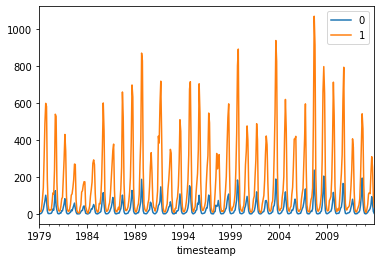

In [80]:
df = pd.read_excel('inflows.xlsx', index_col='timesteamp')
col_nmes = df.columns.values.tolist()
df.columns = [0,1]
df = df.resample('M').mean()
df = df[:-1]
print(df.head())
df.plot()
df = df.reset_index(drop=True)

In [78]:
synthetic_flows = StreamFlowsGeneration(df, monthly=True, sample_size=100)

Qh = synthetic_flows.formatting_Qh(shifted=False)
print(Qh[0].shape)
#print(Qh[0])


(35, 12)


13.744337727999664
(408, 200)


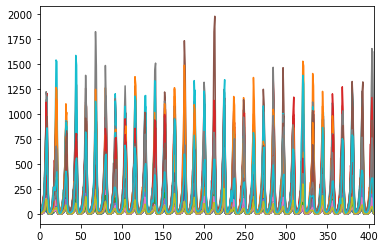

In [79]:
start = perf_counter()
Qs = synthetic_flows.generate_sample()
end = perf_counter()

print(end-start)
print(Qs.shape)
Qs.plot(legend=False)

In [74]:
import warnings
import tables

warnings.filterwarnings('ignore', category=tables.NaturalNameWarning)

nmes = np.unique(Qs.columns.values)

dates = pd.date_range('1979-01-31', periods=408, freq='M')
store = pd.HDFStore('inflows_scenarios.h5', mode='w')

for i in range(len(nmes)):
    
    tem = Qs.loc[:,nmes[i]]
    tem['timesteamp'] = dates
    tem = tem.set_index('timesteamp')

    new_nme = []
    for c, col in enumerate(tem.columns):    
        if col == nmes[i]:
            new_nme.append(c)
            continue
            
        new_nme.append(col)
    
    tem.columns = new_nme
    
    store[col_nmes[i]] = tem
    
store.close()

C:\ANACONDA3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [70]:
with pd.HDFStore('inflows_scenarios.h5') as dfs:
    
    for df in dfs:
        
        tem = pd.DataFrame(dfs.get(df))
        print(df, len(tem))

/Akosombo C1 408
/Bui C8 408


,0,1
count,420.000000,420.000000
mean,30.190228,174.557695
std,39.486912,204.181090
min,0.324645,4.662109
25%,3.144694,26.989746
50%,13.794368,88.243089
75%,44.124466,255.766317
max,237.465534,1069.965685


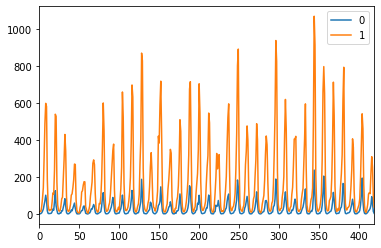

In [49]:
df.plot()
df.describe()